In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Menggunakan perintah pip untuk menginstal paket 'pyrsgis' dari Python Package Index (PyPI)
# 'pyrsgis' adalah sebuah paket Python yang digunakan untuk memproses data penginderaan jauh (remote sensing)
!pip install pyrsgis

In [3]:
# Menggunakan perintah pip untuk menginstal paket 'imagecodecs' dari Python Package Index (PyPI)
# 'imagecodecs' adalah sebuah paket Python yang menyediakan codec untuk membaca dan menulis berbagai format gambar,
# termasuk format gambar kompresi seperti PNG, JPEG, TIFF, dan lainnya.

!pip install imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 25.2 MB/s eta 0:00:00


# Import Library

In [4]:
# Mengimpor paket-paket yang diperlukan
# MaxPooling2D, Conv2D, Dropout, Flatten, Dense: Lapisan-lapisan inti untuk membangun jaringan saraf konvolusional (CNN)
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dropout, Flatten, Dense
# Sequential: Struktur model yang disederhanakan di Keras untuk menumpuk lapisan-lapisan secara berurutan
from tensorflow.keras.models import Sequential
# LabelEncoder: Mengkodekan label kategori menjadi bilangan bulat untuk model machine learning
from sklearn.preprocessing import LabelEncoder
# to_categorical: Mengonversi label bilangan bulat menjadi vektor one-hot encoding
from tensorflow.keras.utils import to_categorical
# train_test_split: Membagi dataset menjadi subset training dan testing
from sklearn.model_selection import train_test_split
# tqdm.notebook: Menampilkan progress bar pada Jupyter notebook
from tqdm.notebook import tqdm
# imread: Membaca file gambar TIFF
from tifffile import imread
# matplotlib.pyplot: Digunakan untuk membuat visualisasi dan plot grafik
import matplotlib.pyplot as plt
# paths: Utilitas untuk menangani jalur file
from imutils import paths
# numpy: Paket utama untuk komputasi numerik
import numpy as np
# os: Menyediakan fungsionalitas yang bergantung pada sistem operasi
import os
# cv2: Library OpenCV untuk pemrosesan gambar
import cv2
# tqdm: Menampilkan progress bar untuk iterasi loop
from tqdm import tqdm
# Image: Modul PIL untuk menangani operasi gambar
from PIL import Image
# paths (diimpor ulang): Kemungkinan digunakan untuk menangani jalur file gambar; sudah diimpor di atas
from imutils import paths


# Load Dataset

In [5]:
# Mengambil daftar gambar dalam direktori dataset menggunakan fungsi list_images dari library 'imutils'
folder_path = list(paths.list_images('/content/drive/MyDrive/Ekik/DatasetAfterSemhas'))
data = []  # Menyimpan gambar yang telah diproses
labels = []  # Menyimpan label kelas untuk setiap gambar

# Melakukan iterasi melalui setiap path gambar dalam folder
for folder_path in tqdm(folder_path, desc="Importing images"):
    # Mengekstrak label kelas dari nama folder (folder kedua dari belakang)
    label = folder_path.split(os.path.sep)[-2]

    # Membuka gambar dengan PIL (Pillow) dan mengonversinya ke format RGB
    image = Image.open(folder_path).convert("RGB")

    # Mengubah ukuran gambar menjadi 224x224 piksel
    image = image.resize((75, 75))

    # Mengonversi gambar menjadi array NumPy
    image = np.array(image)

    # Menambahkan gambar dan label ke dalam daftar data dan labels
    data.append(image)
    labels.append(label)

# Mengonversi data dan labels menjadi array NumPy dengan tipe data float32 untuk kompatibilitas dalam pelatihan model
data = np.array(data)
labels = np.array(labels)

# Menampilkan label yang unik dalam dataset
print(np.unique(labels))

Importing images: 100%|██████████| 1000/1000 [03:52<00:00,  4.30it/s]

['Hutan' 'Non-Hutan']


# Split Dataset

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Lakukan Label Encoding terlebih dahulu
enc = LabelEncoder()
encoded_labels = enc.fit_transform(labels)
# encoded_labels sekarang berisi integer (misalnya, 0, 1)

# 2. Konversi ke One-Hot Encoding setelah Label Encoding
# Reshape untuk OneHotEncoder, yang mengharapkan array 2D
encoded_labels_reshaped = encoded_labels.reshape(-1, 1)
ohe = OneHotEncoder(sparse_output=False) # sparse_output=False memastikan array NumPy padat
one_hot_labels = ohe.fit_transform(encoded_labels_reshaped)
# one_hot_labels sekarang berisi vektor one-hot (misalnya, [1., 0.] atau [0., 1.])

# 3. Data Type untuk Fitur Gambar:
# HAPUS BARIS INI: data_features = np.array(data, dtype="float32")
# Cukup gunakan variabel 'data' yang sudah ada, yang seharusnya masih uint8 dari langkah pemuatan.

# 4. Bagi data menjadi 70% train, 30% temp (validation + test)
trainX, tempX, trainY, tempY = train_test_split(
    data,              # <--- Gunakan 'data' yang masih uint8
    one_hot_labels,    # <--- Gunakan one-hot labels
    test_size=0.30,
    stratify=one_hot_labels, # Stratify pada one-hot labels atau encoded_labels
    random_state=42
)

# 5. Bagi set temp (30%) menjadi 20% validation dan 10% test
# (0.333 dari 30% adalah sekitar 10% dari total)
valX, testX, valY, testY = train_test_split(
    tempX,
    tempY,
    test_size=0.333,
    stratify=tempY, # Stratify harus pada one-hot labels dari temp set
    random_state=42
)

print(f"Shape trainX: {trainX.shape}, dtype: {trainX.dtype}") # Seharusnya uint8
print(f"Shape trainY: {trainY.shape}, dtype: {trainY.dtype}") # Seharusnya float64 (default dari OneHotEncoder)
print(f"Shape valX: {valX.shape}, dtype: {valX.dtype}")       # Seharusnya uint8
print(f"Shape valY: {valY.shape}, dtype: {valY.dtype}")       # Seharusnya float64
print(f"Shape testX: {testX.shape}, dtype: {testX.dtype}")     # Seharusnya uint8
print(f"Shape testY: {testY.shape}, dtype: {testY.dtype}")     # Seharusnya float64

Shape trainX: (700, 75, 75, 3), dtype: uint8
Shape trainY: (700, 2), dtype: float64
Shape valX: (200, 75, 75, 3), dtype: uint8
Shape valY: (200, 2), dtype: float64
Shape testX: (100, 75, 75, 3), dtype: uint8
Shape testY: (100, 2), dtype: float64


# Plot Data

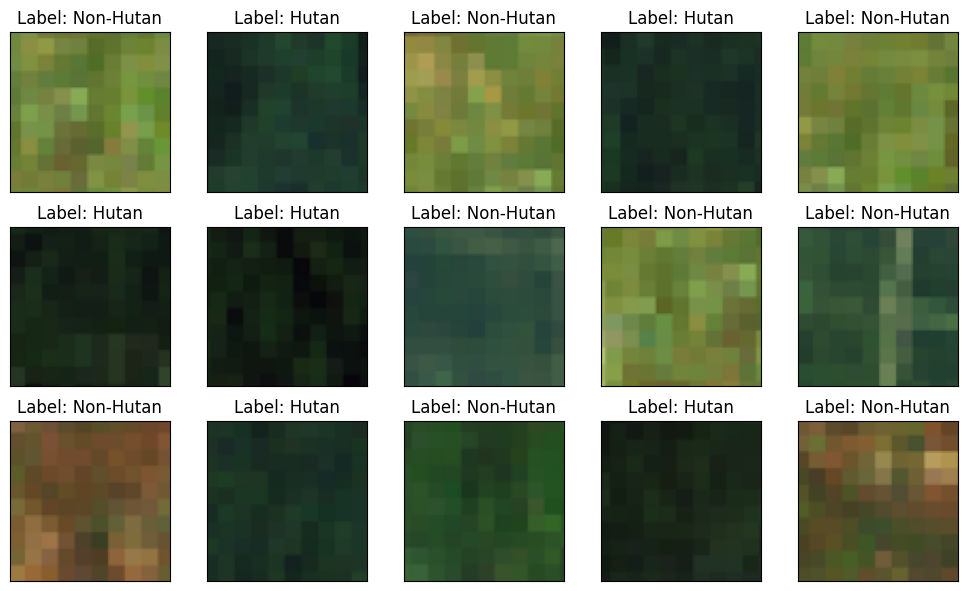

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder # Pastikan ini diimpor jika belum

# Menentukan jumlah baris dan kolom untuk plot
num_row = 3
num_col = 5
num_images_to_display = num_row * num_col

# Membuat figure dan axes untuk plot
fig, axes = plt.subplots(num_row, num_col, figsize=(2 * num_col, 2 * num_row))
axes = axes.flatten()

# Mengonversi enc.classes_ menjadi list nama kelas
class_names = list(enc.classes_)

# Mengambil indeks secara acak untuk ditampilkan
if len(trainX) < num_images_to_display:
    print(f"Warning: trainX has only {len(trainX)} samples, displaying all available.")
    random_indices = np.arange(len(trainX))
else:
    random_indices = np.random.choice(len(trainX), num_images_to_display, replace=False)

# Loop untuk menampilkan gambar
for i, idx in enumerate(random_indices):
    ax = axes[i]

    # Menampilkan gambar
    ax.imshow(trainX[idx])

    # Mengambil dan mengubah label one-hot ke teks
    one_hot_label = trainY[idx]
    predicted_class_index = np.argmax(one_hot_label)
    label_text = class_names[predicted_class_index]

    # Menambahkan judul
    ax.set_title("Label: {}".format(label_text))

    # Sembunyikan ticks dan label pada sumbu
    ax.set_xticks([])
    ax.set_yticks([])

# Mengatur tata letak
plt.tight_layout()

# Menampilkan figure
plt.show()

# AUGMENTASI

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat objek ImageDataGenerator untuk augmentasi gambar pada training set
train_datagen = ImageDataGenerator(
    rotation_range=20,                       # Rotasi gambar secara acak antara -20 hingga +20 derajat
    width_shift_range=0.2,                   # Geser gambar secara horizontal hingga 20% dari lebar gambar
    height_shift_range=0.2,                  # Geser gambar secara vertikal hingga 20% dari tinggi gambar
    shear_range=0.2,                         # Terapkan transformasi shearing (distorsi geser) secara acak
    zoom_range=0.2,                          # Zoom in atau zoom out gambar secara acak hingga 20%
    horizontal_flip=True,                    # Pembalikan gambar secara horizontal secara acak
    vertical_flip=True,                      # Pembalikan gambar secara vertikal secara acak
    fill_mode='nearest'                      # Metode pengisian piksel yang hilang setelah transformasi
)

# Membuat objek ImageDataGenerator untuk validasi set
val_datagen = ImageDataGenerator()  # Tidak ada preprocessing_function di sini

# Membuat generator data untuk training set dengan augmentasi
train_data = train_datagen.flow(trainX, trainY, batch_size=64)

# Membuat generator data untuk validation set tanpa augmentasi, hanya preprocessing
val_data = val_datagen.flow(valX, valY, batch_size=64)


# Arsitektur Model

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
import time

# Base Model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(75, 75, 3))
base_model.trainable = False

# Input Layer
input_tensor = Input(shape=(75, 75, 3))

# Adding Base Model and Custom Layers
x = base_model(input_tensor)
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x) # No activation here
x = BatchNormalization()(x)
x = Activation('relu')(x) # Activation after BN
x = Dropout(0.5)(x)
x = Dense(128)(x) # No activation here
x = BatchNormalization()(x)
x = Activation('relu')(x) # Activation after BN
x = Dropout(0.5)(x)
output_tensor = Dense(2, activation='softmax')(x)

# Model Definition
model_VGG16 = Model(inputs=input_tensor, outputs=output_tensor)

# Compile Model
model_VGG16.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print Model Summary
model_VGG16.summary()

# ================================
# START TRAINING WITH TIME TRACKING
# ================================
epochs = 50

print("\nMemulai pelatihan model...\n")
start_time = time.time()

history = model_VGG16.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

end_time = time.time()
training_time = end_time - start_time
minutes = int(training_time // 60)
seconds = int(training_time % 60)
average_epoch_time = training_time / epochs

print(f"\nWaktu total pelatihan: {minutes} menit {seconds} detik")
print(f"Rata-rata waktu per epoch: {average_epoch_time:.2f} detik")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 75, 75, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,880,706 (56.77 MB)

 Trainable params: 165,250 (645.51 KB)

 Non-trainable params: 14,715,456 (56.14 MB)


Memulai pelatihan model...

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 878ms/step - accuracy: 0.5014 - loss: 0.9621 - val_accuracy: 0.5100 - val_loss: 0.7831
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.6316 - loss: 0.7436 - val_accuracy: 0.5000 - val_loss: 0.9046
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7412 - loss: 0.5858 - val_accuracy: 0.5000 - val_loss: 0.9511
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7842 - loss: 0.4795 - val_accuracy: 0.5050 - val_loss: 0.9214
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.7925 - loss: 0.4550 - val_accuracy: 0.5200 - val_loss: 0.8603
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8075 - loss: 0.4585 - val_accuracy: 0.5250 - val_loss: 0.8074
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8239 - loss: 0.4260 - val_accuracy: 0.5500 - val_loss: 0.7289
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.8270 - loss: 0.3803 - val_accuracy: 0.6450 - val

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Tambahkan ini untuk test set Anda ---
test_datagen = ImageDataGenerator()

# Buat generator data untuk test set
# batch_size bisa sama atau berbeda, tergantung kebutuhan. 64 adalah standar yang baik.
test_data = test_datagen.flow(testX, testY, batch_size=64, shuffle=False)

# =========================================================================

print("\nMemulai evaluasi model pada test set...")

# Evaluasi model menggunakan generator data test_data
test_loss, test_accuracy = model_VGG16.evaluate(test_data)

print(f"Test Accuracy: {test_accuracy:.4f}") # Format output agar lebih mudah dibaca
print(f"Test Loss: {test_loss:.4f}")



Memulai evaluasi model pada test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9577 - loss: 0.1067
Test Accuracy: 0.9600
Test Loss: 0.1009


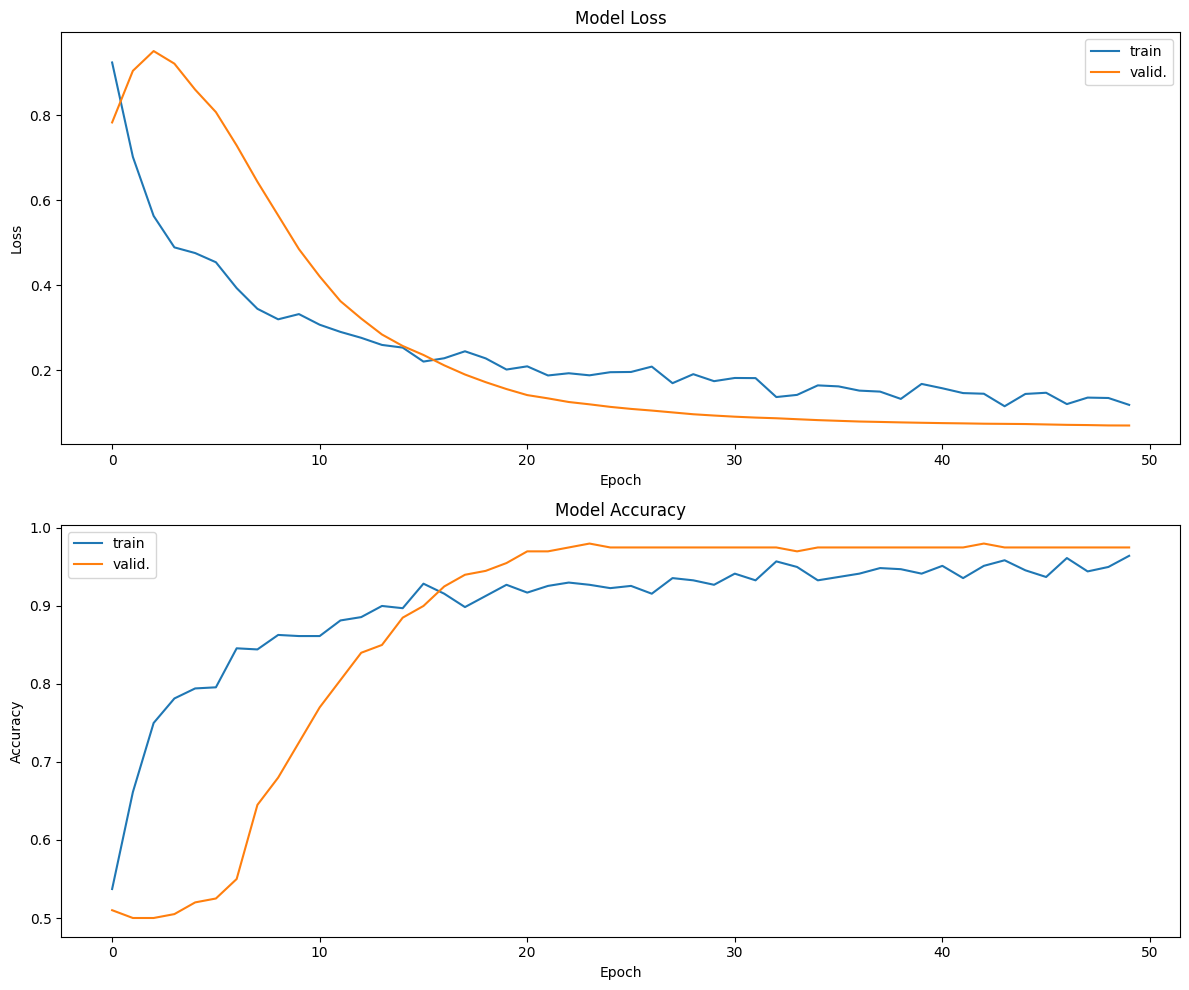

In [12]:
# Mengimpor library matplotlib.pyplot untuk membuat plot
import matplotlib.pyplot as plt

# Fungsi untuk mem-plot training dan validation accuracy serta loss
def plot_training(history):
    # Menentukan ukuran figure untuk plot
    plt.figure(figsize=(12, 10))

    # Plot Loss (Kerugian)
    plt.subplot(2, 1, 1)  # Membuat subplot pada posisi baris 1, kolom 1
    plt.plot(history.history['loss'], label='train')  # Plot loss pada data training
    plt.plot(history.history['val_loss'], label='valid.')  # Plot loss pada data validasi
    plt.title('Model Loss')  # Judul plot untuk loss
    plt.ylabel('Loss')  # Label sumbu Y untuk loss
    plt.xlabel('Epoch')  # Label sumbu X untuk epoch
    plt.legend()  # Menampilkan legenda untuk plot

    # Plot Accuracy
    plt.subplot(2, 1, 2)  # Membuat subplot pada posisi baris 2, kolom 1
    plt.plot(history.history['accuracy'], label='train')  # Plot akurasi pada data training
    plt.plot(history.history['val_accuracy'], label='valid.')  # Plot akurasi pada data validasi
    plt.title('Model Accuracy')  # Judul plot untuk akurasi
    plt.ylabel('Accuracy')  # Label sumbu Y untuk akurasi
    plt.xlabel('Epoch')  # Label sumbu X untuk epoch
    plt.legend()  # Menampilkan legenda untuk plot

    plt.tight_layout()  # Menyusun tata letak plot agar tidak tumpang tindih
    plt.show()  # Menampilkan plot

# Memanggil fungsi untuk menampilkan plot training history
plot_training(history)

# Evaluasi Model


Memulai prediksi pada test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 917ms/step


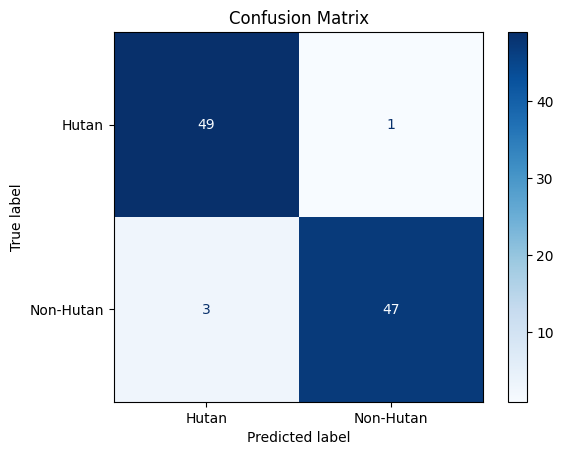


Confusion Matrix berhasil divisualisasikan.


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

print("\nMemulai prediksi pada test set...")

# Prediksi data uji menggunakan generator data test_data
# Menggunakan generator memastikan data diproses dengan preprocess_input
predictions = model_VGG16.predict(test_data)

# Mengambil prediksi label dengan memilih label dengan probabilitas tertinggi (softmax)
y_pred = np.argmax(predictions, axis=1) # Mengambil indeks kelas dengan probabilitas tertinggi

y_true = np.argmax(testY, axis=1) # Mengambil indeks kelas dari one-hot true labels

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred) # Menghitung confusion matrix

class_names = ['Hutan', 'Non-Hutan'] # Ganti dengan nama kelas aktual Anda

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d') # Menampilkan angka bulat di dalam kotak
plt.title("Confusion Matrix")
plt.show()

print("\nConfusion Matrix berhasil divisualisasikan.")

In [14]:
from sklearn.metrics import classification_report
import numpy as np


print("\nMemulai prediksi untuk Classification Report...")

# Prediksi data uji menggunakan generator data test_data
# Ini memastikan data diproses dengan preprocess_input
predictions = model_VGG16.predict(test_data)

# Mengambil prediksi label dengan memilih label dengan probabilitas tertinggi (softmax)
y_pred = np.argmax(predictions, axis=1) # Mengambil indeks kelas dengan probabilitas tertinggi

# Mengambil label asli (true labels) dari testY
# Karena testY Anda sudah one-hot encoded, kita tinggal menggunakan np.argmax
y_true = np.argmax(testY, axis=1) # Mengambil indeks kelas dari one-hot true labels

target_class_names = ['Hutan', 'Non-Hutan'] # Ganti dengan nama kelas aktual Anda

# Membuat classification report
report = classification_report(y_true, y_pred, target_names=target_class_names)

# Menampilkan classification report
print("Classification Report:")
print(report)

print("\nClassification Report berhasil dibuat.")


Memulai prediksi untuk Classification Report...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Classification Report:
              precision    recall  f1-score   support

       Hutan       0.94      0.98      0.96        50
   Non-Hutan       0.98      0.94      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100


Classification Report berhasil dibuat.


# Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_random_images(testX, y_true, y_pred, class_names, num_images=15):
    """
    1) Pilih 'num_images' data secara acak dari testX, y_true, y_pred
    2) Tampilkan (plot) gambar-gambar tersebut
    """
    # -- A. Buat indeks acak --
    indices = np.random.permutation(len(testX))[:num_images]

    # -- B. Ambil subset data --
    random_testX = testX[indices]
    random_y_true = y_true[indices]
    random_y_pred = y_pred[indices]

    # -- C. KONVERSI data agar sesuai rentang valid Matplotlib --
    # Misal: data float32 di [0..255] -> convert ke [0..255] uint8
    random_testX_uint8 = np.clip(random_testX, 0, 255).astype(np.uint8)

    # -- D. Plotting --
    plt.figure(figsize=(15, 5))  # bebas menyesuaikan
    for i in range(num_images):
        plt.subplot(3, 5, i + 1)  # 3 baris x 5 kolom
        plt.imshow(random_testX_uint8[i])

        color = 'green' if random_y_true[i] == random_y_pred[i] else 'red'
        plt.title(
            f"Pred: {class_names[random_y_pred[i]]}\n"
            f"True: {class_names[random_y_true[i]]}",
            color=color
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()


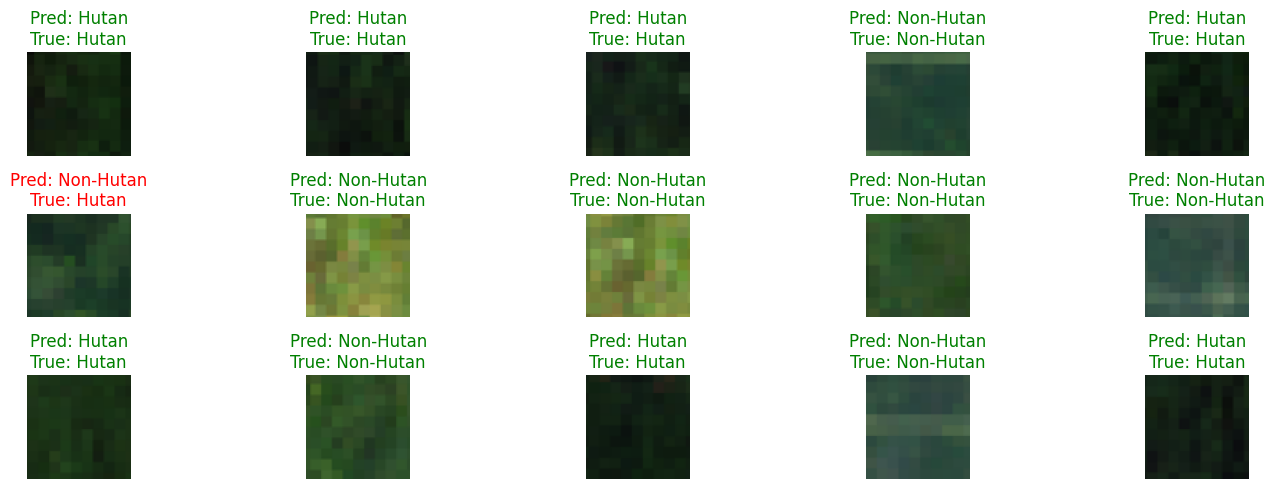

In [ ]:
class_names=['Hutan', 'Non-Hutan']
plot_random_images(
    testX=testX,
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    num_images=15
)

# Pengujian Data Baru

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path ke folder test
test_folder = '/content/drive/MyDrive/Skripsi/DatasetFix/Non-Hutan'  # Ganti dengan folder yang benar

# Membaca semua gambar dalam folder
test_images = []
image_names = []  # Menyimpan nama gambar untuk referensi

for file_name in os.listdir(test_folder):
    # Buat path lengkap untuk setiap gambar
    img_path = os.path.join(test_folder, file_name)

    # Pastikan file adalah gambar
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        try:
            # Load gambar dan ubah ukurannya sesuai input model
            img = load_img(img_path, target_size=(75, 75))

            # Ubah gambar menjadi array NumPy
            img_array = img_to_array(img)

            # Tambahkan dimensi batch (batch_size, height, width, channels)
            img_array = np.expand_dims(img_array, axis=0)

            # Simpan ke daftar
            test_images.append(img_array)
            image_names.append(file_name)

        except Exception as e:
            print(f"Error memproses gambar {file_name}: {e}")

# Konversi daftar ke array NumPy
test_images = np.vstack(test_images)  # Gabungkan semua gambar ke satu array

print(f"Jumlah gambar yang diproses: {len(test_images)}")


Jumlah gambar yang diproses: 500


In [ ]:
# Use model for prediction
predictions = model_VGG16.predict(test_images)

# Get predicted class labels from probabilities
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

class_labels = ["Hutan", "Non-Hutan"]
for i, label in enumerate(predicted_classes):  # Use 'predicted_classes' here
    print(f"Gambar: {image_names[i]} → Prediksi: {class_labels[label]}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step
Gambar: NH101.tiff → Prediksi: Non-Hutan
Gambar: NH102.tiff → Prediksi: Non-Hutan
Gambar: NH103.tiff → Prediksi: Non-Hutan
Gambar: NH112.tiff → Prediksi: Non-Hutan
Gambar: NH114.tiff → Prediksi: Non-Hutan
Gambar: NH119.tiff → Prediksi: Non-Hutan
Gambar: NH120.tiff → Prediksi: Non-Hutan
Gambar: NH149.tiff → Prediksi: Non-Hutan
Gambar: NH150.tiff → Prediksi: Non-Hutan
Gambar: NH62.tiff → Prediksi: Non-Hutan
Gambar: NH63.tiff → Prediksi: Non-Hutan
Gambar: NH64.tiff → Prediksi: Non-Hutan
Gambar: NH65.tiff → Prediksi: Non-Hutan
Gambar: NH66.tiff → Prediksi: Non-Hutan
Gambar: NH67.tiff → Prediksi: Non-Hutan
Gambar: NH68.tiff → Prediksi: Non-Hutan
Gambar: NH69.tiff → Prediksi: Non-Hutan
Gambar: NH70.tiff → Prediksi: Non-Hutan
Gambar: NH71.tiff → Prediksi: Non-Hutan
Gambar: NH72.tiff → Prediksi: Non-Hutan
Gambar: NH73.tiff → Prediksi: Non-Hutan
Gambar: NH74.tiff → Prediksi: Non-Hutan
Gambar: NH75.tiff → Prediksi: Non-Hutan
Gambar: NH76.tiff → Prediksi: 

# Save Model

In [15]:
# Menyimpan model
model_VGG16.save("/content/drive/MyDrive/Ekik/ModelRevisi/Fix9685VGG16(50)Revisi.h5")

# # Menampilkan konfirmasi
print("Model berhasil disimpan sebagai Fix9685VGG16(50)Revisi.h5")

Model berhasil disimpan sebagai Fix9685VGG16(50)Revisi.h5
